# Process resources consumption based on top

Create a top report for a process pid running this command for some time:

```bash
top -b -p 14061 | tee low_res.report
```

Kill the top process after gathering enough data.

In [1]:
%matplotlib notebook

import pandas as pd
import matplotlib.pyplot as plt
import re

In [12]:
# Regular expressions for line 1 and 7 of the report.

L0_T = r"top - ([0-9:]+) up.*load average: ([0-9,.]+), ([0-9,.]+), ([0-9,.]+)"
L7_T = r"[0-9]+ +root +[0-9]+ +[0-9]+ +([0-9]+) " \
       r"+([0-9]+) +([0-9]+) +[a-zA-Z*] +([0-9,.]+) +([0-9,.]+) +"

def topfile2dataframe(path):
    with open(path, 'r') as f:
        data = [x.strip("\n") for x in f.readlines()]
        
    result = []
    idx = 0
    lines = len(data)

    l0_r = re.compile(L0_T)
    l7_r = re.compile(L7_T)

    while idx < lines:
        # line 0: time, load average 1, 5, 15
        r = l0_r.search(data[idx])
        s_time = r.group(1)
        la1, la5, la15 = [float(r.group(x).replace(',', '.')) for x in (2, 3, 4)]
        
        # line 7: process information
        r = l7_r.search(data[idx + 7])
        m_virt = int(r.group(1))
        m_res = int(r.group(2))
        m_shared = int(r.group(3))
        cpu = float(r.group(4).replace(',', '.'))
        m_percent = float(r.group(4).replace(',', '.'))
    
        row = (s_time, la1, la5, la15, m_virt, m_res, m_shared, cpu, m_percent)
        result.append(row)
        idx += 9

    df = pd.DataFrame(result, columns=(
        'Time', 'LA1', 'LA5', 'LA15', 'VIRT', 'RES', 'SHARED', 'CPU%', 'MEM%')
    )
    return df

In [15]:
df_lr = topfile2dataframe('low_res.report')
df_lr.describe()

,LA1,LA5,LA15,VIRT,RES,SHARED,CPU%,MEM%
count,1929.000000,1929.000000,1929.000000,1929.0,1929.000000,1929.0,1929.000000,1929.000000
mean,0.952395,0.916454,0.820098,1061176.0,169832.437532,43196.0,21.874650,21.874650
std,0.233405,0.133797,0.176673,0.0,3047.622244,0.0,1.781194,1.781194
min,0.440000,0.340000,0.200000,1061176.0,164660.000000,43196.0,16.300000,16.300000
25%,0.790000,0.850000,0.820000,1061176.0,167172.000000,43196.0,20.700000,20.700000
50%,0.930000,0.930000,0.880000,1061176.0,172444.000000,43196.0,21.900000,21.900000
75%,1.090000,1.000000,0.920000,1061176.0,172444.000000,43196.0,23.000000,23.000000
max,1.850000,1.270000,1.050000,1061176.0,172444.000000,43196.0,40.000000,40.000000


<IPython.core.display.Javascript object>


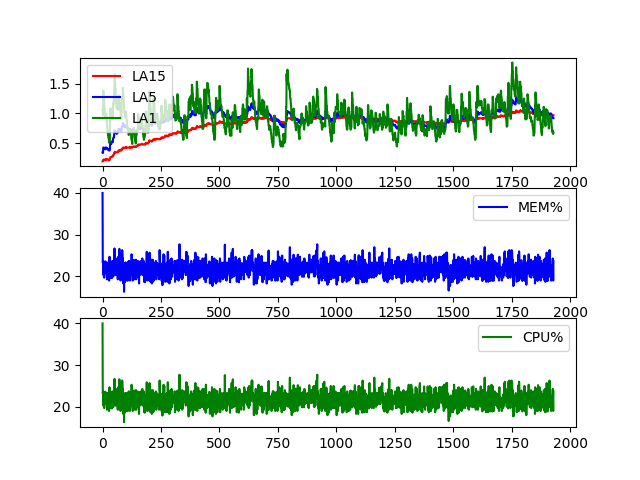

In [37]:
fig, (ax_la, ax_m, ax_c) = plt.subplots(3, 1)

df_lr.plot(kind='line', y='LA15', color='red', ax=ax_la)
df_lr.plot(kind='line', y='LA5', color='blue', ax=ax_la)
df_lr.plot(kind='line', y='LA1', color='green', ax=ax_la)

df_lr.plot(kind='line', y='MEM%', color='blue', ax=ax_m)

df_lr.plot(kind='line', y='CPU%', color='green', ax=ax_c)

plt.show()